## Warnings

In [2]:
import warnings

warnings.filterwarnings('ignore')

## Imports

In [ ]:
import polars as pl
import pandas as pd
import pygwalker as pyg
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import polars.selectors as cs
from janitor.polars import clean_names
from ydata_profiling import ProfileReport
from scipy.stats.contingency import association
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE
import altair as alt
import os

current_path = os.getcwd()

# Dataset Deals

In [ ]:
dataset_path = os.path.join(current_path, "data", "Project_Phase1.csv")
pandas_df = pd.read_csv(dataset_path)
polars_df = pl.from_pandas(pandas_df)

In [ ]:
polars_df.shape

In [ ]:
polars_df.schema

In [ ]:
polars_df = clean_names(df=polars_df, case_type='lower', remove_special=True, strip_accents=True,
                        strip_underscores=True, truncate_limit=None)

In [ ]:
polars_df.null_count()

In [ ]:
polars_df.select(cs.numeric()).describe()

In [ ]:
polars_df.select(cs.string()).describe()

In [ ]:
polars_df.columns

In [ ]:
polars_df = polars_df.rename({"class": "target"})

In [ ]:
profile = ProfileReport(pandas_df, title="Pred-Sus-Act Report", lazy=True, explorative=True, tsmode=True)

In [ ]:
report_path = os.path.join(current_path, "data", "report.html")
profile.to_file(report_path)

## Extra Visuals

In [ ]:
%matplotlib inline

for col in polars_df.columns:
    if col != "target":
        plt.figure(figsize=(8, 5))  # Set figure size for each plot
        sns.scatterplot(x=col, y="target", hue="target", data=polars_df)
        plt.title(f'{col} vs Target')
        plt.show()


In [ ]:
plt.figure(figsize=(20, 5), dpi=500)

sns.boxplot(
    data=polars_df,
    showfliers=False,  # hide extreme outliers
    boxprops=dict(facecolor="lightblue", linewidth=2),  # box styling
    whiskerprops=dict(color="blue", linewidth=2, linestyle="--"),
    medianprops=dict(color="darkred", linewidth=2),
    capprops=dict(color="blue", linewidth=2),
    gap=1.5
)

plt.show()

In [ ]:
[polars_df.columns[11], polars_df.columns[15], polars_df.columns[24], polars_df.columns[27]]

## Analysis Playground

In [ ]:
pyg.walk(polars_df, kernel_computation=True, appearance="dark", theme_key="vega")

## User Defined Functions (UDF)

In [ ]:
def skimmer(df: pl.DataFrame) -> dict:
    out = {}
    for col in df.columns:
        if df[col].dtype == pl.Utf8:
            out[f"{col}"] = {"col_unique_values": df[col].unique().to_list(), "data_type": df[col].dtype}
        else:
            out[f"{col}"] = {"col_values_range": [df[col].min(), df[col].max()], "data_type": df[col].dtype}
    return out

## Handling Unbalanced Target Classes Problem

In [8]:
polars_df["target"].value_counts()

target,count
str,u32
"""normal""",13449
"""anomaly""",587


Text(0.5, 1.0, 'Unbalanced Classes Distribution')

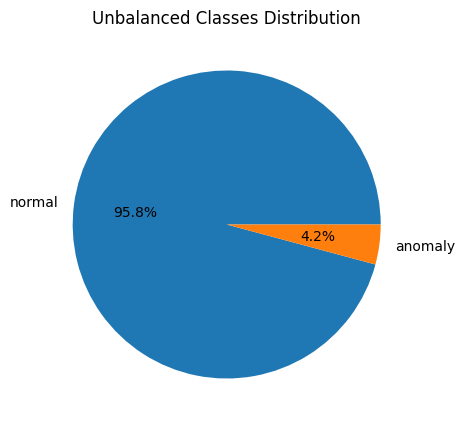

In [10]:
plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=polars_df["target"].value_counts()["count"], labels=polars_df["target"].value_counts()["target"],
        autopct="%1.1f%%")
plt.title("Unbalanced Classes Distribution")

## Feature Engineering & Selection

In [8]:
from buckaroo import disable;

disable()
scaler = StandardScaler()
X = (polars_df.drop('target').select(cs.numeric()))  # All features except the target
X_scaled = scaler.fit_transform(X)
y = polars_df['target']  # Target variable
f_statistic, p_values = f_classif(X_scaled, y)
data = {"col_name": X.columns, "f_statistic": f_statistic, "p_values": p_values}
annova = pl.DataFrame(data)
filtered_annova = annova.filter((pl.col("p_values") <= 0.05) & (pl.col("f_statistic") >= pl.mean("f_statistic") - 2200))
mostCoRELATED = filtered_annova['col_name'].to_list()
filtered_annova


The default DataFrame displayers have been restored. To re-enable Buckaroo use `from buckaroo import enable; enable()`


col_name,f_statistic,p_values
str,f64,f64
"""syn_error_rate""",10571.025841,0.0
"""connection_count""",2848.992744,0.0
"""destination_server_syn_error_r…",14813.838093,0.0
"""destination_host_server_count""",1743.53087,0.0
"""destination_same_server_rate""",2092.916738,0.0
"""destination_syn_error_rate""",10941.375787,0.0
"""same_server_rate""",9530.965368,0.0
"""server_syn_error_rate""",11419.807349,0.0
"""authentication_status""",1252.844566,6.0988e-263


In [17]:
selector = SelectKBest(score_func=f_classif, k=10)  #Validating the feature selection

X_new = selector.fit_transform(X_scaled, y)

selected_indices = selector.get_support(indices=True)
print(selected_indices)
selected_features = [X.columns[i] for i in selected_indices]
print("Selected features:", selected_features)


[ 0  4  8  9 10 14 15 20 23 24]
Selected features: ['syn_error_rate', 'connection_count', 'destination_server_syn_error_rate', 'destination_host_server_count', 'destination_same_server_rate', 'destination_syn_error_rate', 'same_server_rate', 'server_syn_error_rate', 'authentication_status', 'destination_host_count']


In [12]:

for col in polars_df.select(pl.col(pl.Utf8)):
    #https://medium.com/aiskunks/categorical-data-encoding-techniques-d6296697a40f
    if col.name == "target":
        continue
    s = polars_df[[col.name, "target"]].to_pandas()
    mostCoRELATED.append(col.name)
    small_batch = pd.get_dummies(s, dtype=int).to_numpy()
    # print(small_batch)
    correlation = association(small_batch, method="cramer")
    print(col.name, col.unique().shape[0], "       ", correlation)


# association(obs4x2, method="cramer")

connection_status 10         0.6741998624632421
protocol 3         0.6123724356957946
service_type 62         0.7014723744122018


In [13]:
features = polars_df[mostCoRELATED].to_pandas()
features = pd.get_dummies(data=features, dtype=int)
featuresSCALED = scaler.fit_transform(features)
PCA_featuresSCALED = PCA(n_components=2).fit_transform(featuresSCALED)
PCA_featuresSCALED_WITH_Target = pl.DataFrame(
    {"comp1": PCA_featuresSCALED[:, 0], "comp2": PCA_featuresSCALED[:, 0], "label": polars_df["target"]})
print(PCA_featuresSCALED.shape)

(14036, 2)


In [19]:
PCA_featuresSCALED_WITH_Target

comp1,comp2,label
f64,f64,str
-1.017223,-1.017223,"""anomaly"""
14.736542,14.736542,"""anomaly"""
14.589532,14.589532,"""anomaly"""
14.708902,14.708902,"""anomaly"""
14.556786,14.556786,"""anomaly"""
…,…,…
0.508028,0.508028,"""normal"""
-1.172782,-1.172782,"""normal"""
0.136637,0.136637,"""normal"""


In [57]:
X_resampled.shape, PCA_featuresSCALED.shape, y_resampled.shape, type(y_resampled)

((26899, 2), (14036, 2), (26899,), pandas.core.series.Series)

## Testing SMOTE VS ADASYN

In [12]:
#I'm using oversampling as undersampling works by removing samples of the majority class and I don't want to lose any data
#https://medium.com/@abdallahashraf90x/oversampling-for-better-machine-learning-with-imbalanced-data-68f9b5ac2696
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
"""
We need to know which 1 will be working good with the data and why?
RandomOverSampler
SMOTE
SMOTENC prefered
SMOTEN
ADASYN
BorderlineSMOTE
KMeansSMOTE
SVMSMOTE
"""

'\nWe need to know which 1 will be working good with the data and why?\nRandomOverSampler\nSMOTE\nSMOTENC prefered\nSMOTEN\nADASYN\nBorderlineSMOTE\nKMeansSMOTE\nSVMSMOTE\n'

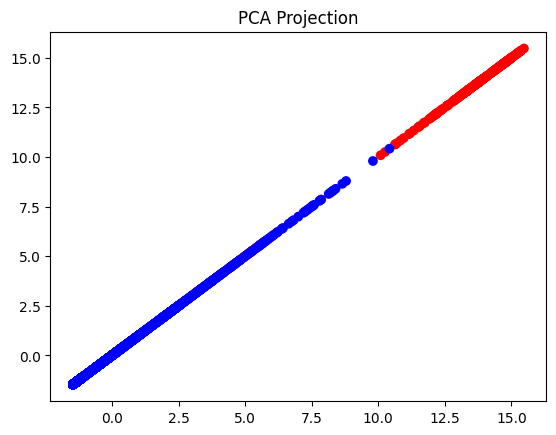

In [21]:
colorsMAP = {"anomaly": "red", "normal": "blue"}
plt.scatter(PCA_featuresSCALED_WITH_Target["comp1"],
            PCA_featuresSCALED_WITH_Target["comp2"],
            c=PCA_featuresSCALED_WITH_Target["label"].replace(colorsMAP)
            )  #https://stackoverflow.com/questions/74779644/mapping-a-python-dict-to-a-polars-series , https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/
plt.title("PCA Projection")
plt.show()

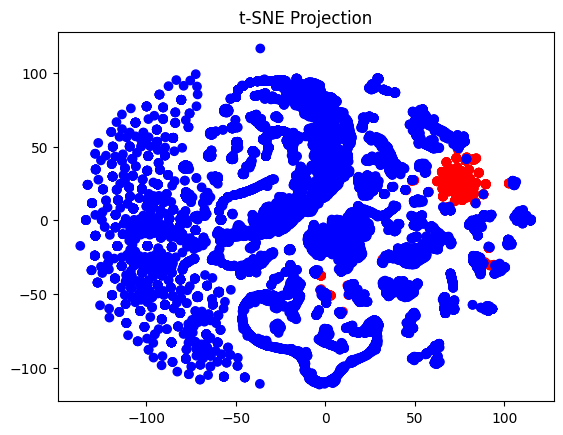

In [22]:
from sklearn.manifold import TSNE

# https://medium.com/analytics-vidhya/pca-vs-t-sne-17bcd882bf3d , https://dev.to/sreeni5018/pca-vs-t-sne-unveiling-the-best-dimensionality-reduction-technique-for-your-data-ekc
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(featuresSCALED)

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=PCA_featuresSCALED_WITH_Target["label"].replace(colorsMAP))
plt.title("t-SNE Projection")
plt.show()


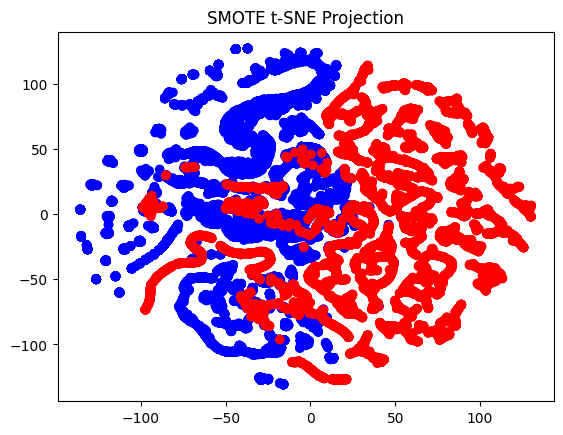

In [53]:
X_resampled, y_resampled = SMOTE().fit_resample(PCA_featuresSCALED, PCA_featuresSCALED_WITH_Target["label"])
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X_resampled)

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=y_resampled.replace(colorsMAP))
plt.title("SMOTE t-SNE Projection")
plt.show()

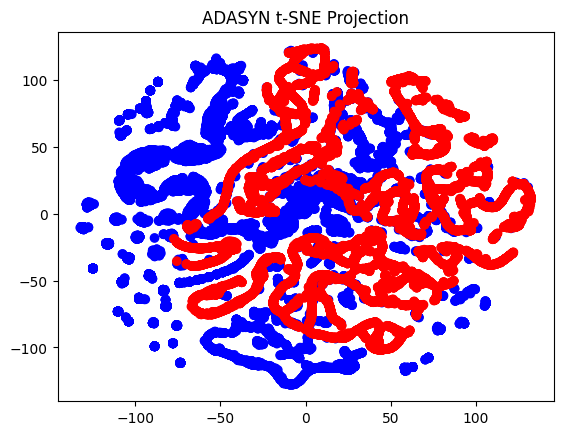

In [54]:
X_resampled, y_resampled = ADASYN().fit_resample(PCA_featuresSCALED, PCA_featuresSCALED_WITH_Target["label"])
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X_resampled)

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=y_resampled.replace(colorsMAP))
plt.title("ADASYN t-SNE Projection")
plt.show()

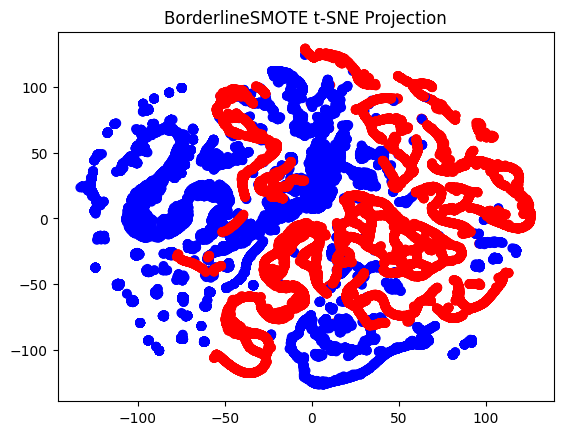

In [55]:
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(PCA_featuresSCALED, PCA_featuresSCALED_WITH_Target["label"])
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X_resampled)

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=y_resampled.replace(colorsMAP))
plt.title("BorderlineSMOTE t-SNE Projection")
plt.show()

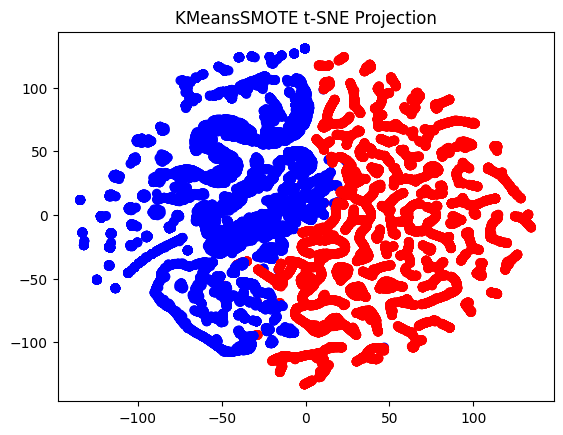

In [56]:
X_resampled, y_resampled = KMeansSMOTE().fit_resample(PCA_featuresSCALED, PCA_featuresSCALED_WITH_Target["label"])
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X_resampled)

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=y_resampled.replace(colorsMAP))
plt.title("KMeansSMOTE t-SNE Projection")
X
plt.show()

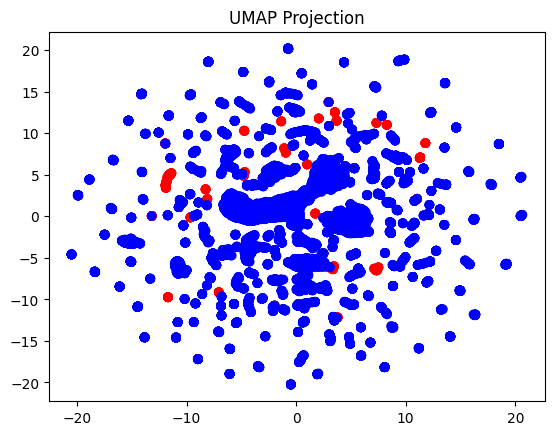

In [54]:
import umap

# https://medium.com/analytics-vidhya/pca-vs-t-sne-17bcd882bf3d  , https://www.reddit.com/r/datascience/comments/wy1rmk/pca_vs_umap_vs_tsne_on_a_very_layman_level_what/
# https://medium.com/@aastha.code/dimensionality-reduction-pca-t-sne-and-umap-41d499da2df2
umap_model = umap.UMAP(n_components=2)
umap_data = umap_model.fit_transform(featuresSCALED)

plt.scatter(umap_data[:, 0], umap_data[:, 1],
            c=PCA_featuresSCALED_WITH_Target["label"].replace(colorsMAP)
            )
plt.title("UMAP Projection")
plt.show()


## Exporting Datasets After Solving Classes Un-balance

In [69]:
pd.concat([pd.DataFrame(X_resampled), y_resampled], axis=1, ignore_index=True).to_csv("data/KMeansSMOTE_Reduced.csv",
                                                                                      index=False)
# type(X_resampled) ,type( y_resampled)

In [80]:
#Chosen KMEAN-SMOTE
X_resampled, y_resampled = KMeansSMOTE().fit_resample(featuresSCALED, polars_df["target"])
pd.concat([pd.DataFrame(X_resampled), y_resampled], axis=1, ignore_index=True).to_csv(
    "data/KMeansSMOTE_Y_SelectedFeatures.csv", index=False)
O_M_CF = pd.read_csv("data/chosen_features.csv")
X_resampled, y_resampled = KMeansSMOTE().fit_resample(O_M_CF.drop(columns=["class"]), O_M_CF["class"])
y_resampled
pd.concat([pd.DataFrame(X_resampled), y_resampled], axis=1, ignore_index=True).to_csv(
    "data/KMeansSMOTE_O_M_SelectedFeatures.csv", index=False)

In [78]:
O_M_CF

,destination_different_server_rate,destination_server_reset_error_rate,different_server_rate,destination_host_count,reset_error_rate,destination_host_server_count,same_server_rate,server_syn_error_rate,destination_same_source_port_rate,destination_same_server_rate,...,service_type_urp_i,service_type_uucp,service_type_uucp_path,service_type_vmnet,connection_status_RSTO,connection_status_RSTR,connection_status_S0,connection_status_S1,protocol_udp,class
0,0.00,0.01,0.00,87,0.0,87,1.00,0.00,0.01,1.00,...,0,0,0,0,0,0,0,0,0,anomaly
1,0.07,0.00,0.07,255,0.0,6,0.02,1.00,0.00,0.02,...,0,0,0,0,0,0,1,0,0,anomaly
2,0.08,0.00,0.06,255,0.0,12,0.07,1.00,0.00,0.05,...,0,0,0,0,0,0,1,0,0,anomaly
3,0.08,0.00,0.06,255,0.0,1,0.01,1.00,0.00,0.00,...,0,0,0,0,0,0,1,0,0,anomaly
4,0.07,0.00,0.06,255,0.0,11,0.09,1.00,0.00,0.04,...,0,0,0,0,0,0,1,0,0,anomaly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14031,0.07,0.00,0.00,58,0.0,27,1.00,0.00,0.12,0.12,...,0,0,0,0,0,0,0,0,0,normal
14032,0.00,0.00,0.00,255,0.0,255,1.00,0.00,0.00,1.00,...,0,0,0,0,0,0,0,0,0,normal
14033,0.02,0.10,0.00,255,0.0,60,1.00,0.00,0.00,0.24,...,0,0,0,0,0,0,0,0,0,normal
14034,0.17,0.00,0.00,12,0.0,11,1.00,0.00,0.08,0.92,...,0,0,0,0,0,0,0,0,0,normal


## SyntaxTesting

In [ ]:
polars_df["protocol"].unique()

In [ ]:
polars_df.select(cs.string()).unique()

In [ ]:
html = strip_markdown("#your_text_string\nt")
print(html)

In [ ]:
polars_df["connection_count"].plot.hist()

In [ ]:
polars_df["target"]